# Chapter 3: Current frequency of threshold exceedance

In this chapter the current frequency of the threshold, determined in chapter 2, wil be analysed. This is done using the HBV model through eWaterCycle. The HBV model....

## General

First of all, some general python and eWaterCycle libraries need to be imported:

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

eWaterCycle provides access to the Caravan dataset. This dataset contains data on rainfall, potential evaporation and discharge for all the catchments in the different Camel datasets. The Caravan dataset contains a Camel dataset of the catchment of the Wien River. This catchment area is loaded below:

In [2]:
camelsgb_id = "lamah_208082"

The start and end date of the experiment have to be specified:

In [3]:
experiment_start_date = "1979-08-01T00:00:00Z"
experiment_end_date = "2023-08-31T00:00:00Z"

The forcing data can be generated or previously generated data can be loaded:

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# option one: generate forcing data
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    directory=forcing_path_caravan,
    basin_id=camelsgb_id,
)


# # option two or three: load data that you or someone else generated previously
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

# print(camelsgb_forcing)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below. The data contains the maximum discharge values per day.

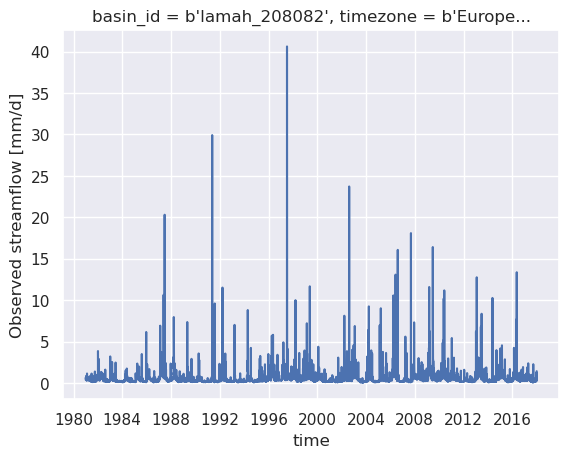

In [6]:
#quick plot of the discharge data. 
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

Since the threshold values determined in chapter 2 are in m3/s, the observed discharge data, now in mm/d, is converted to m3/s as well.

Text(0, 0.5, 'observed streaflow [$m^3$/s]')

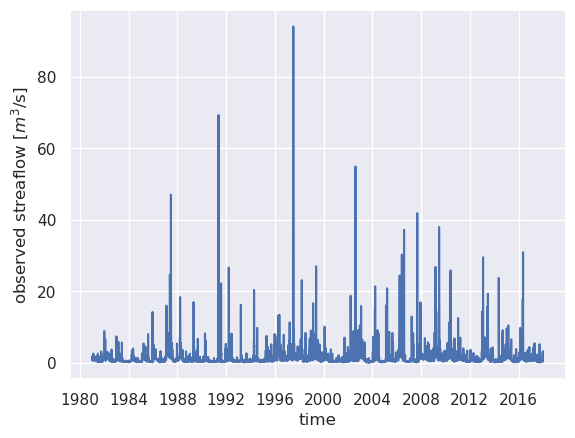

In [8]:
#Load the forcing dataset
ds = xr.open_dataset("/home/thirza/forcing/lamah_208082/caravan/lamah_208082_1979-08-01_2023-08-31_pr.nc")

catchment_area = ds["area"].values

# go from mm/day to m3/s
discharge = []
for i in range(len(ds_forcing["Q"].values)):
    discharge.append((ds_forcing["Q"].values[i] * catchment_area * 1000) / (24 * 60 * 60))

x = ds["time"].values
y = discharge

plt.plot(x,y)
plt.xlabel('time')
plt.ylabel('observed streaflow [$m^3$/s]')

The maximum discharge of the observed data is:

In [9]:
max(discharge)

94.05234565654797

This discharged can be used to calculate the returnperiods of the normally distributed threshold values. This is done using the Generalized Extreme Value distribution. The return period of the mean threshold value of 534 m3/s is calculated below: 

# nog meer uitleggen en aanpassen!!!

In [10]:
# Find the maximum annual discharge
max_discharge = ds_forcing["Q"].groupby("time.year").max()
maxdischarge = max_discharge.values * catchment_area * 1000 / (24 * 60 * 60) #convert to m3/s
# print(maxdischarge)

In [11]:
import scipy.stats as stats
import math
# # discharge data > 20 m³/s
# data = [value for value in discharge if value > 20]

# # all discharge data
# cleaned_discharge = [x for x in discharge if not math.isnan(x)]
# data = cleaned_discharge

# maximum annual discharge
data = [x for x in maxdischarge if not math.isnan(x)]
# print(data)

# Generalized Extreme Value (GEV) distribution 
shape, loc, scale = stats.genextreme.fit(data)

# Define threshold value
threshold = 530

# calculate exceedance probability in years
p = 1 - stats.genextreme.cdf(threshold, shape, loc=loc, scale=scale)
# calculate return period in years
T = 1 / (p)
# print(T)

# calculate change threshold exceedance at least once in 1000 and 1100 years
P_1000 = 1 - (1 - p) ** 1000
P_1100 = 1 - (1 - p) ** 1100

# Results 1000
print(f"Returnperiod for 530 m³/s: {T:.2f} years")
print(f"Chance of at least one exceedance in 1000 years: {P_1000:.5f} ({P_1000 * 100:.2f}%)")
print(f"Chance of at least one exceedance in 1100 years: {P_1100:.5f} ({P_1100 * 100:.2f}%)")

# expected amount of times threshold is exceeded in 1000 years
expected_exceedances1000 = 1000 / T if T > 0 else 0
print(f"The discharge currently exceeds the threshold of 530 m³/s {expected_exceedances1000:.3f} times in 1000 years")

# expected amount threshold is exceeded in 1100 years
expected_exceedances1100 = 1100 / T if T > 0 else 0
print(f"The discharge currently exceeds the threshold of 530 m³/s {expected_exceedances1100:.3f} times in 1100 years")

Returnperiod for 530 m³/s: 1398.68 years

Chance of at least one exceedance in 1000 years: 0.51091 (51.09%)

Chance of at least one exceedance in 1100 years: 0.54467 (54.47%)

The discharge currently exceeds the threshold of 530 m³/s 0.715 times in 1000 years

The discharge currently exceeds the threshold of 530 m³/s 0.786 times in 1100 years

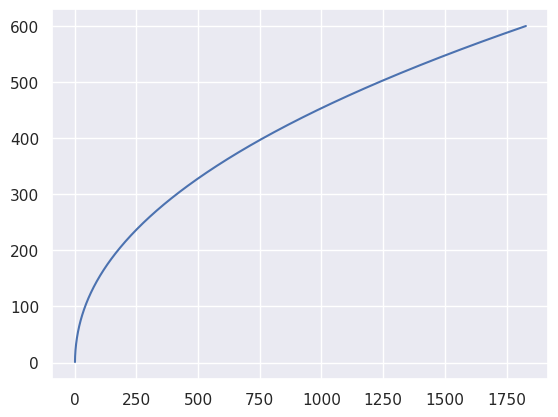

In [12]:
import scipy.stats as stats
import math
# # discharge data > 20 m³/s
# data = [value for value in discharge if value > 20]

# # all discharge data
# cleaned_discharge = [x for x in discharge if not math.isnan(x)]
# data = cleaned_discharge

# maximum annual discharge
data = [x for x in maxdischarge if not math.isnan(x)]
# print(data)

# Generalized Extreme Value (GEV) distribution 
shape, loc, scale = stats.genextreme.fit(data)

# Define threshold value
threshold = np.linspace(1, 600, 600)

return_period = []
prob = []
for i in range(len(threshold)):
# calculate exceedance probability in years
    p = 1 - stats.genextreme.cdf(threshold[i], shape, loc=loc, scale=scale)
    prob.append(p)
# calculate return period in years
    T = 1 / p 
    return_period.append(T)
# print(return_period)

plt.plot(return_period, threshold)